# Superstore Sales Workflow Tutorial

This notebook walks through cleaning the Superstore dataset, designing a relational structure, creating an SQLite database, and running example SQL queries and visualizations.

In [2]:
import sys
!{sys.executable} -m pip install pandas matplotlib seaborn

import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker


[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## 1️) Load and Inspect the Dataset

In [3]:
# reading error codes + research is how you can learn if there is different encoding, as seen below
df = pd.read_csv('../data/Superstore.csv', encoding='ISO-8859-1')
df.head()
df.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='str')

### Double check some datatypes, and for nulls and duplicates:

In [4]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   str    
 2   Order Date     9994 non-null   str    
 3   Ship Date      9994 non-null   str    
 4   Ship Mode      9994 non-null   str    
 5   Customer ID    9994 non-null   str    
 6   Customer Name  9994 non-null   str    
 7   Segment        9994 non-null   str    
 8   Country        9994 non-null   str    
 9   City           9994 non-null   str    
 10  State          9994 non-null   str    
 11  Postal Code    9994 non-null   int64  
 12  Region         9994 non-null   str    
 13  Product ID     9994 non-null   str    
 14  Category       9994 non-null   str    
 15  Sub-Category   9994 non-null   str    
 16  Product Name   9994 non-null   str    
 17  Sales          9994 non-null   float64
 18  Quantity       9994

In [5]:
df.duplicated().sum()

np.int64(0)

In [6]:
df.isnull().sum()

Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64

This data is incredibly clean - we can see there are no null values and no duplicates. However, there are some dates that could be saved in a better format.

## 2) Data Cleaning

In [7]:
df['Order Date'] = pd.to_datetime(df['Order Date'], dayfirst=True)
df['Ship Date'] = pd.to_datetime(df['Ship Date'], dayfirst=True)

In [8]:
df.dtypes

Row ID                    int64
Order ID                    str
Order Date       datetime64[us]
Ship Date        datetime64[us]
Ship Mode                   str
Customer ID                 str
Customer Name               str
Segment                     str
Country                     str
City                        str
State                       str
Postal Code               int64
Region                      str
Product ID                  str
Category                    str
Sub-Category                str
Product Name                str
Sales                   float64
Quantity                  int64
Discount                float64
Profit                  float64
dtype: object

In [9]:
df.Segment.unique()

<StringArray>
['Consumer', 'Corporate', 'Home Office']
Length: 3, dtype: str

In [10]:
df.rename(columns={"Segment":"customer_category"}, inplace=True)
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,customer_category,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2013-152156,2013-11-09,2013-11-12,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2013-152156,2013-11-09,2013-11-12,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2013-138688,2013-06-13,2013-06-17,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2012-108966,2012-10-11,2012-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2012-108966,2012-10-11,2012-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


With real data, it is very likely more cleaning and wrangling would be required. 

## 3) Build Relational Tables

In [11]:
conn = sqlite3.connect('../data/superstore.db')

customers_df = df[['Customer ID','Customer Name','customer_category','City','State','Region', 'Postal Code']].drop_duplicates().rename(columns={
    'Customer ID':'customer_id',
    'Customer Name':'customer_name',
    'City':'city',
    'State':'state',
    'Region':'region',
    'Postal Code': 'zipcode'
})

products_df = df[['Product ID','Category','Sub-Category','Product Name']].drop_duplicates().rename(columns={
    'Product ID':'product_id',
    'Category':'category',
    'Sub-Category':'subcategory',
    'Product Name':'product_name'
})

orders_df = df[['Order ID','Order Date','Ship Date','Ship Mode','Customer ID']].drop_duplicates().rename(columns={
    'Order ID':'order_id',
    'Order Date':'order_date',
    'Ship Date':'ship_date',
    'Ship Mode':'ship_mode',
    'Customer ID':'customer_id'
})

order_details_df = df[['Order ID','Product ID','Sales','Quantity','Discount','Profit']].rename(columns={
    'Order ID':'order_id',
    'Product ID':'product_id'
})


customers_df.to_sql('customers', conn, index=False, if_exists='replace')
products_df.to_sql('products', conn, index=False, if_exists='replace')
orders_df.to_sql('orders', conn, index=False, if_exists='replace')
order_details_df.to_sql('order_details', conn, index=False, if_exists='replace')
conn.commit()

In [12]:
for name, df in [
    ('customers', customers_df),
    ("products", products_df),
    ("orders", orders_df),
    ("order_details", order_details_df)
]:
    df.to_csv(f'../data/{name}.csv')

## 4) Make Some Queries!

### Which customer segments bring in the most revenue and profit?

In [13]:
query1 = """ SELECT 
    c.customer_category,
    ROUND(SUM(od.sales), 2) AS total_sales,
    ROUND(SUM(od.profit), 2) AS total_profit
FROM order_details od
JOIN orders o ON od.order_id = o.order_id
JOIN customers c ON o.customer_id = c.customer_id
GROUP BY c.customer_category
ORDER BY total_sales DESC;
"""
result1 = pd.read_sql(query1, conn)
result1

,customer_category,total_sales,total_profit
0,Consumer,8380282.43,973085.86
1,Corporate,5044899.83,660287.69
2,Home Office,2964459.36,434344.01


### What are the top 10 customers by total sales?

In [14]:
query2 = """ SELECT 
    c.customer_id,
    c.customer_name,
    ROUND(SUM(od.Sales), 2) AS total_sales
FROM customers c
JOIN orders o
    ON c.customer_id = o.customer_id
JOIN order_details od
    ON o.order_id = od.order_id
GROUP BY 
    c.customer_id,
    c.customer_name
ORDER BY total_sales DESC
LIMIT 10;
"""
result2 = pd.read_sql(query2, conn)
result2

,customer_id,customer_name,total_sales
0,KL-16645,Ken Lonsdale,155927.52
1,SE-20110,Sanjit Engle,134303.82
2,CL-12565,Clay Ludtke,130566.55
3,AB-10105,Adrian Barton,130262.14
4,SC-20095,Sanjit Chand,127281.01
5,SM-20320,Sean Miller,125215.25
6,EH-13765,Edward Hooks,123730.56
7,GT-14710,Greg Tran,118201.20
8,SV-20365,Seth Vernon,114709.50
9,JL-15835,John Lee,107799.15


### Which product categories and subcategories are the most profitable overall?

In [15]:
query3 = """SELECT
    p.category,
    p.subcategory,
    ROUND(SUM(od.Profit), 2) AS total_profit
FROM products p
JOIN order_details od
    ON p.product_id = od.product_id
GROUP BY
    p.category,
    p.subcategory
ORDER BY total_profit DESC
LIMIT 10;
"""
result3 = pd.read_sql(query3, conn)
result3

,category,subcategory,total_profit
0,Technology,Copiers,55617.82
1,Technology,Accessories,48359.05
2,Technology,Phones,46936.19
3,Office Supplies,Paper,36994.53
4,Office Supplies,Binders,30373.20
5,Furniture,Chairs,26707.65
6,Office Supplies,Storage,21408.70
7,Office Supplies,Appliances,18514.49
8,Furniture,Furnishings,14569.59
9,Office Supplies,Envelopes,6964.18


### What is the average discount given per category?

In [16]:
query4 = """SELECT
    p.category,
    ROUND(AVG(od.Discount), 4) AS avg_discount
FROM products p
JOIN order_details od
    ON p.product_id = od.product_id
GROUP BY
    p.category
ORDER BY avg_discount DESC;
"""
result4 = pd.read_sql(query4, conn)
result4

,category,avg_discount
0,Furniture,0.1725
1,Office Supplies,0.1570
2,Technology,0.1330


### Which states or regions contribute the most to total sales?

In [17]:
query5 = """SELECT
    c.region,
    ROUND(SUM(od.Sales), 2) AS total_sales
FROM customers c
JOIN orders o
    ON c.customer_id = o.customer_id
JOIN order_details od
    ON o.order_id = od.order_id
GROUP BY
    c.region
ORDER BY total_sales DESC;
"""
result5 = pd.read_sql(query5, conn)
result5

,region,total_sales
0,West,5306522.06
1,East,4522990.06
2,Central,3853691.95
3,South,2706437.54


### How many orders were shipped late (where Ship Date > Order Date + 3 days)?

In [18]:
query6 = """SELECT
    COUNT(*) AS late_orders
FROM orders
WHERE ship_date > DATETIME(order_date, '+3 days');
"""
result6 = pd.read_sql(query6, conn)
result6

,late_orders
0,3391


### Which month or year had the highest total sales?

In [19]:
query7 = """SELECT
    strftime('%Y', o.order_date) AS year,
    ROUND(SUM(od.Sales), 2) AS total_sales
FROM orders o
JOIN order_details od
    ON o.order_id = od.order_id
GROUP BY year
ORDER BY total_sales DESC
LIMIT 1;
"""
result7 = pd.read_sql(query7, conn)
result7

,year,total_sales
0,2014,733947.02


### What are the most frequently ordered products?

In [20]:
query8 = """SELECT
    p.product_name,
    SUM(od.Quantity) AS total_quantity_sold
FROM products p
JOIN order_details od
    ON p.product_id = od.product_id
GROUP BY
    p.product_name
ORDER BY total_quantity_sold DESC
LIMIT 25;
"""
result8 = pd.read_sql(query8, conn)
result8

,product_name,total_quantity_sold
0,Staples,876
1,Logitech P710e Mobile Speakerphone,75
2,Imation 16GB Mini TravelDrive USB 2.0 Flash Drive,75
3,KI Adjustable-Height Table,74
4,Storex Dura Pro Binders,71
5,Avery Non-Stick Binders,71
6,Xerox 1908,70
7,Xerox 1881,70
8,GBC Premium Transparent Covers with Diagonal L...,67
9,"Situations Contoured Folding Chairs, 4/Set",64


### Which customers placed more than 5 orders total?

In [21]:
query9 = """SELECT
    c.customer_id,
    c.customer_name,
    COUNT(o.order_id) AS total_orders
FROM customers c
JOIN orders o
    ON c.customer_id = o.customer_id
GROUP BY
    c.customer_id,
    c.customer_name
HAVING COUNT(o.order_id) > 5
ORDER BY total_orders DESC;
"""
result9 = pd.read_sql(query9, conn)
result9

,customer_id,customer_name,total_orders
0,EP-13915,Emily Phan,289
1,EA-14035,Erin Ashbrook,169
2,JE-15745,Joel Eaton,169
3,SH-19975,Sally Hughsby,169
4,ZC-21910,Zuschuss Carroll,169
...,...,...,...
742,SS-20515,Shirley Schmidt,9
743,SW-20350,Sean Wendt,9
744,TM-21490,Tony Molinari,9
745,TT-21265,Tim Taslimi,9


### What’s the profit margin (profit ÷ sales) by category or segment?

In [22]:
query10 = """SELECT
    p.category,
    ROUND(SUM(od.Profit), 2) AS total_profit,
    ROUND(SUM(od.Sales), 2) AS total_sales,
    ROUND(SUM(od.Profit) * 1.0 / SUM(od.Sales), 4) AS profit_margin
FROM products p
JOIN order_details od
    ON p.product_id = od.product_id
GROUP BY p.category
ORDER BY profit_margin DESC;
"""
result10 = pd.read_sql(query10, conn)
result10

,category,total_profit,total_sales,profit_margin
0,Technology,153415.70,893633.28,0.1717
1,Office Supplies,126113.35,736748.59,0.1712
2,Furniture,20098.89,764284.65,0.0263


### 5) Visualize it!

From your ten results, select at least 4 to utilize in a meaningful visualization. 

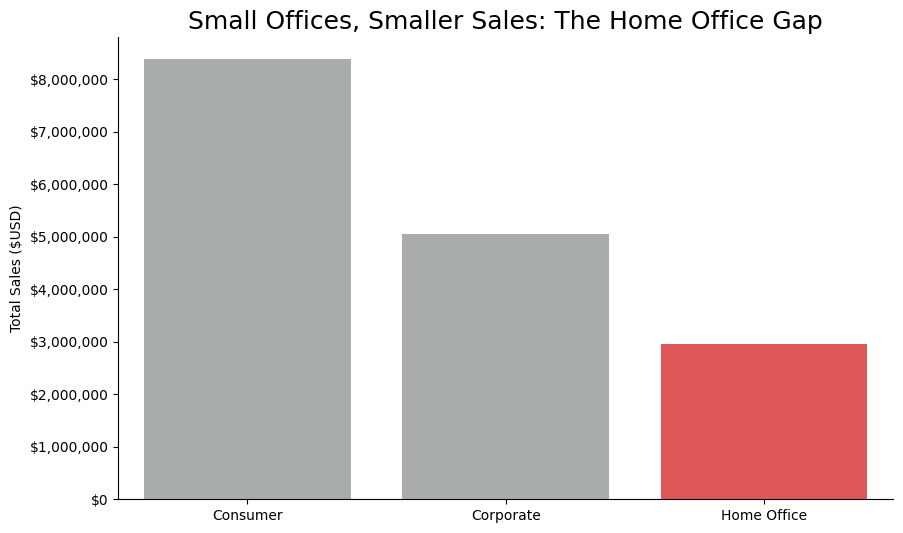

In [23]:
# example using result1
plt.figure(figsize=(10,6))
colors = ["#a7adaa", "#a7adaa", "#f74141" ]
sns.barplot(result1, x='customer_category', y='total_sales', palette=colors, hue='customer_category', legend=False)
plt.title('Small Offices, Smaller Sales: The Home Office Gap',fontsize=18)
plt.xlabel(None)
plt.ylabel('Total Sales ($USD)')

#for those wondering how to get rid of scientific notation! Set style to plain:
plt.ticklabel_format(style='plain', axis='y')

#mticker is a great library for helping tick mark formatting, such as adding commas and dollar signs in this case
ax = plt.gca()
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x:,.0f}'))

#using the seaborn library, despining is way easier!
sns.despine()
plt.show()


C:\Users\ryanh\AppData\Local\Temp\ipykernel_31244\2118643372.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(result4, x='category', y='avg_discount', palette=colors, legend=False)


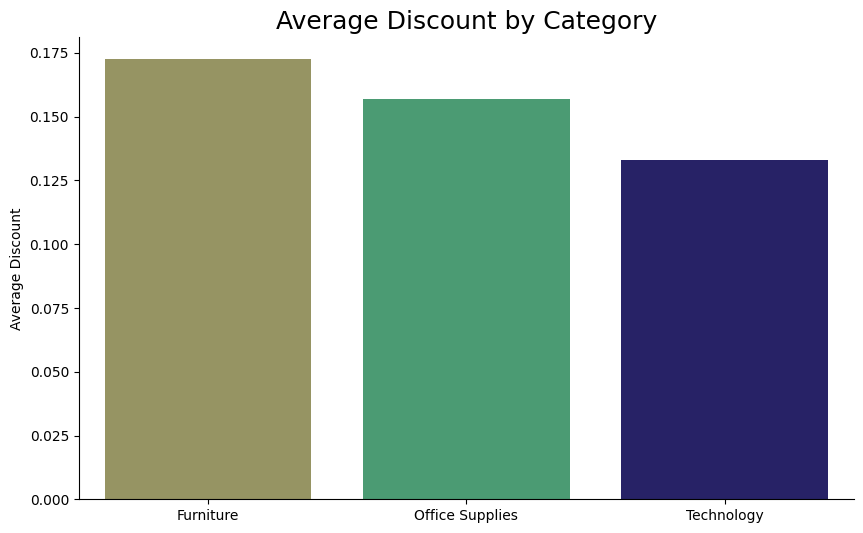

In [24]:
# visualization one code here
plt.figure(figsize=(10,6))
colors = ["#9e9c5b", "#3da973", "#1e1771" ]
sns.barplot(result4, x='category', y='avg_discount', palette=colors, legend=False)
plt.title('Average Discount by Category',fontsize=18)
plt.xlabel(None)
plt.ylabel('Average Discount')
plt.ticklabel_format(style='plain', axis='y')
ax = plt.gca()
sns.despine()
plt.show()




C:\Users\ryanh\AppData\Local\Temp\ipykernel_31244\1908928901.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(result2, x='customer_name', y='total_sales', palette=colors, legend=False)


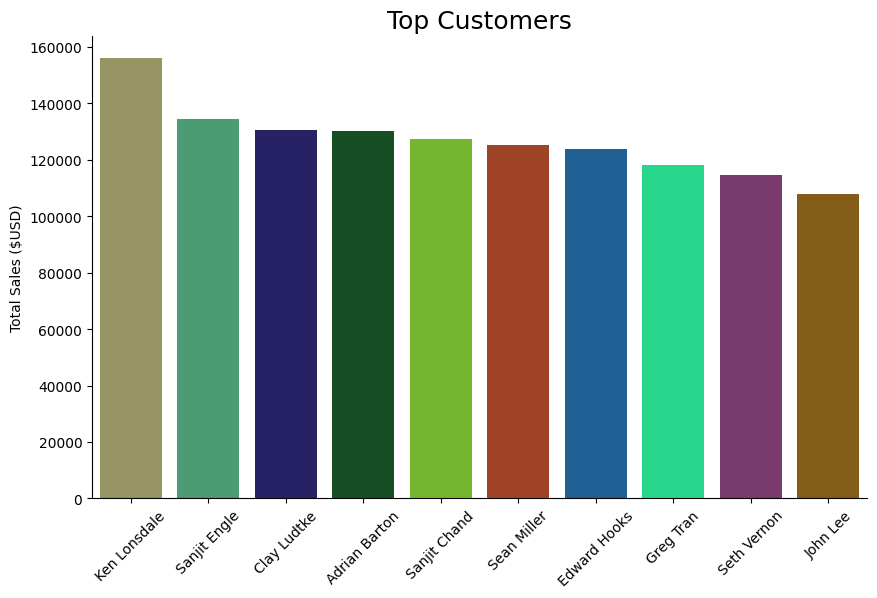

In [25]:
# visualization two code here
plt.figure(figsize=(10,6))
colors = ["#9e9c5b", "#3da973", "#1e1771", "#0D581E", "#76CC1B", "#b43914", "#0C62A8", "#0bf48f", "#833075", "#956205" ]
sns.barplot(result2, x='customer_name', y='total_sales', palette=colors, legend=False)
plt.title('Top Customers',fontsize=18)
plt.xlabel(None)
plt.ylabel('Total Sales ($USD)')
plt.ticklabel_format(style='plain', axis='y')
ax = plt.gca()
sns.despine()
plt.xticks(rotation=45)
plt.show()


C:\Users\ryanh\AppData\Local\Temp\ipykernel_31244\2135072139.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(result3, x='subcategory', y='total_profit', palette=colors, legend=False)


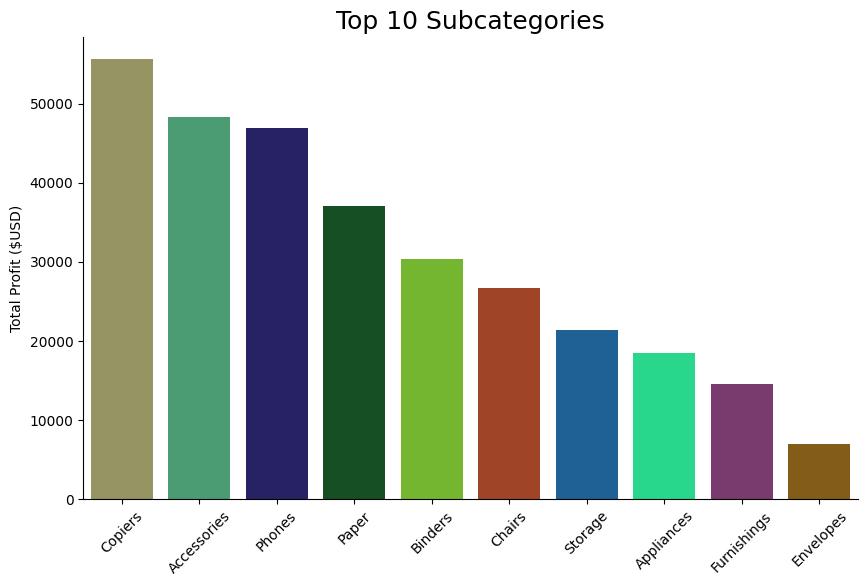

In [26]:
# visualization three code here
plt.figure(figsize=(10,6))
colors = ["#9e9c5b", "#3da973", "#1e1771", "#0D581E", "#76CC1B", "#b43914", "#0C62A8", "#0bf48f", "#833075", "#956205" ]
sns.barplot(result3, x='subcategory', y='total_profit', palette=colors, legend=False)
plt.title('Top 10 Subcategories',fontsize=18)
plt.xlabel(None)
plt.ylabel('Total Profit ($USD)')
plt.ticklabel_format(style='plain', axis='y')
ax = plt.gca()
sns.despine()
plt.xticks(rotation=45)
plt.show()

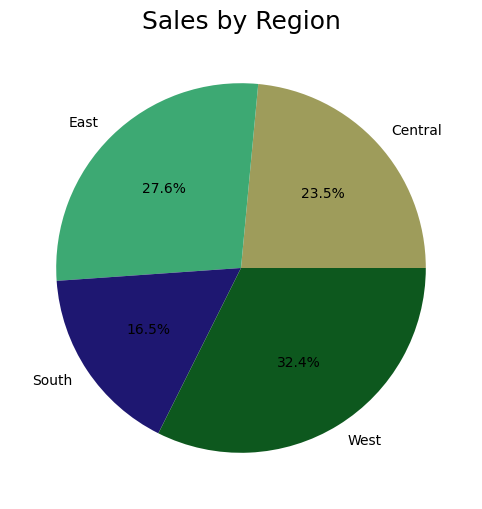

In [27]:
# visualization four code here
plt.figure(figsize=(10,6))
result5.groupby('region')['total_sales'].sum().plot.pie(autopct="%1.1f%%", colors=colors)
colors = ["#9e9c5b", "#376f3b", "#7F2427", "#393179"]
plt.title('Sales by Region',fontsize=18)
plt.xlabel(None)
plt.ylabel(None)
plt.show()
